# Molecular Diffusion with DeepChem and GNNs

This notebook explores molecular data from DeepChem and prepares it for GNN-based diffusion models.
The core model implementations are in separate scripts for scalability.


In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import warnings
warnings.filterwarnings('ignore')

from diffusion_gnn.data.deepchem import DeepChemMolecularDataset
from diffusion_gnn.models.mol_diff_gnn import MolecularDiffusionGNN, MolecularDDPM
from diffusion_gnn.utils.mol_diff_gnn import visualize_molecule, plot_training_metrics


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/jantine/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning depende

# Dataset Exploration

In [2]:
# Start with small molecules first
dataset = DeepChemMolecularDataset('tox21', max_atoms=30)

print(f"Dataset: {dataset.dataset_name}")
print(f"Number of molecules: {len(dataset.dataset)}")
print(f"Max atoms allowed: {dataset.max_atoms}")
print(f"Atom feature dimension: {dataset._get_atom_feature_dim()}")
print(f"Bond feature dimension: {dataset._get_bond_feature_dim()}")


INFO:diffusion_gnn.data.deepchem:Loading DeepChem dataset: tox21
INFO:deepchem.molnet.load_function.molnet_loader:About to featurize tox21 dataset.
INFO:deepchem.data.data_loader:Loading raw samples now.
INFO:deepchem.data.data_loader:shard_size: 8192
INFO:deepchem.utils.data_utils:About to start loading CSV from /tmp/tox21.csv.gz
INFO:deepchem.utils.data_utils:Loading shard 1 of size 8192.
INFO:deepchem.data.data_loader:About to featurize shard.
INFO:deepchem.feat.base_classes:Featurizing datapoint 0
[14:38:08] WARNING: not removing hydrogen atom without neighbors
INFO:deepchem.feat.base_classes:Featurizing datapoint 1000
[14:38:08] Explicit valence for atom # 8 Al, 6, is greater than permitted
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
INFO:deepchem.feat.base_classes:F

Dataset: tox21
Number of molecules: 6258
Max atoms allowed: 30
Atom feature dimension: 37
Bond feature dimension: 10


In [3]:
# Let's examine some raw SMILES from the dataset
sample_smiles = []
for i in range(10):
    smiles = dataset.dataset.ids[i]
    sample_smiles.append(smiles)
    print(f"{i+1:2d}: {smiles}")

 1: CC(O)(P(=O)(O)O)P(=O)(O)O
 2: CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
 3: OC[C@H](O)[C@@H](O)[C@H](O)CO
 4: CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
 5: CC(C)COC(=O)C(C)C
 6: C=C(C)C(=O)OCCOC(=O)C(=C)C
 7: CCCCCCCCCCOCC(O)CN
 8: C#CCO
 9: CC(O)CC(C)(C)O
10: CC(C)(C)CC(C)(C)N


# Molecular Property Analysis

In [4]:
# Analyze molecular properties
def analyze_molecules(smiles_list, max_analyze=1000):
    """Analyze basic molecular properties"""
    properties = {
        'num_atoms': [],
        'num_bonds': [],
        'molecular_weight': [],
        'logp': [],
        'num_rings': [],
        'smiles': []
    }

    valid_count = 0
    for smiles in smiles_list[:max_analyze]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            properties['num_atoms'].append(mol.GetNumAtoms())
            properties['num_bonds'].append(mol.GetNumBonds())
            properties['molecular_weight'].append(Descriptors.MolWt(mol))
            properties['logp'].append(Descriptors.MolLogP(mol))
            properties['num_rings'].append(Descriptors.RingCount(mol))
            properties['smiles'].append(smiles)
            valid_count += 1

    print(f"Analyzed {valid_count} valid molecules out of {len(smiles_list[:max_analyze])}")
    return pd.DataFrame(properties)


In [5]:
# Analyze the dataset
all_smiles = [dataset.dataset.ids[i] for i in range(len(dataset.dataset))]
mol_df = analyze_molecules(all_smiles, max_analyze=2000)

# Display basic statistics
print("\nMolecular Property Statistics:")
print(mol_df.describe())

[14:38:23] WARNING: not removing hydrogen atom without neighbors


Analyzed 2000 valid molecules out of 2000

Molecular Property Statistics:
         num_atoms    num_bonds  molecular_weight         logp   num_rings
count  2000.000000  2000.000000       2000.000000  2000.000000  2000.00000
mean     11.798000    10.870500        189.812914     1.765332     0.11250
std       6.669215     6.693066        100.286992     2.394732     0.31606
min       1.000000     0.000000          9.012000   -10.036400     0.00000
25%       7.000000     6.000000        122.155250     0.379030     0.00000
50%      10.000000    10.000000        164.831000     1.567650     0.00000
75%      14.000000    13.000000        229.120500     2.956775     0.00000
max      57.000000    56.000000        807.339000    16.428500     1.00000


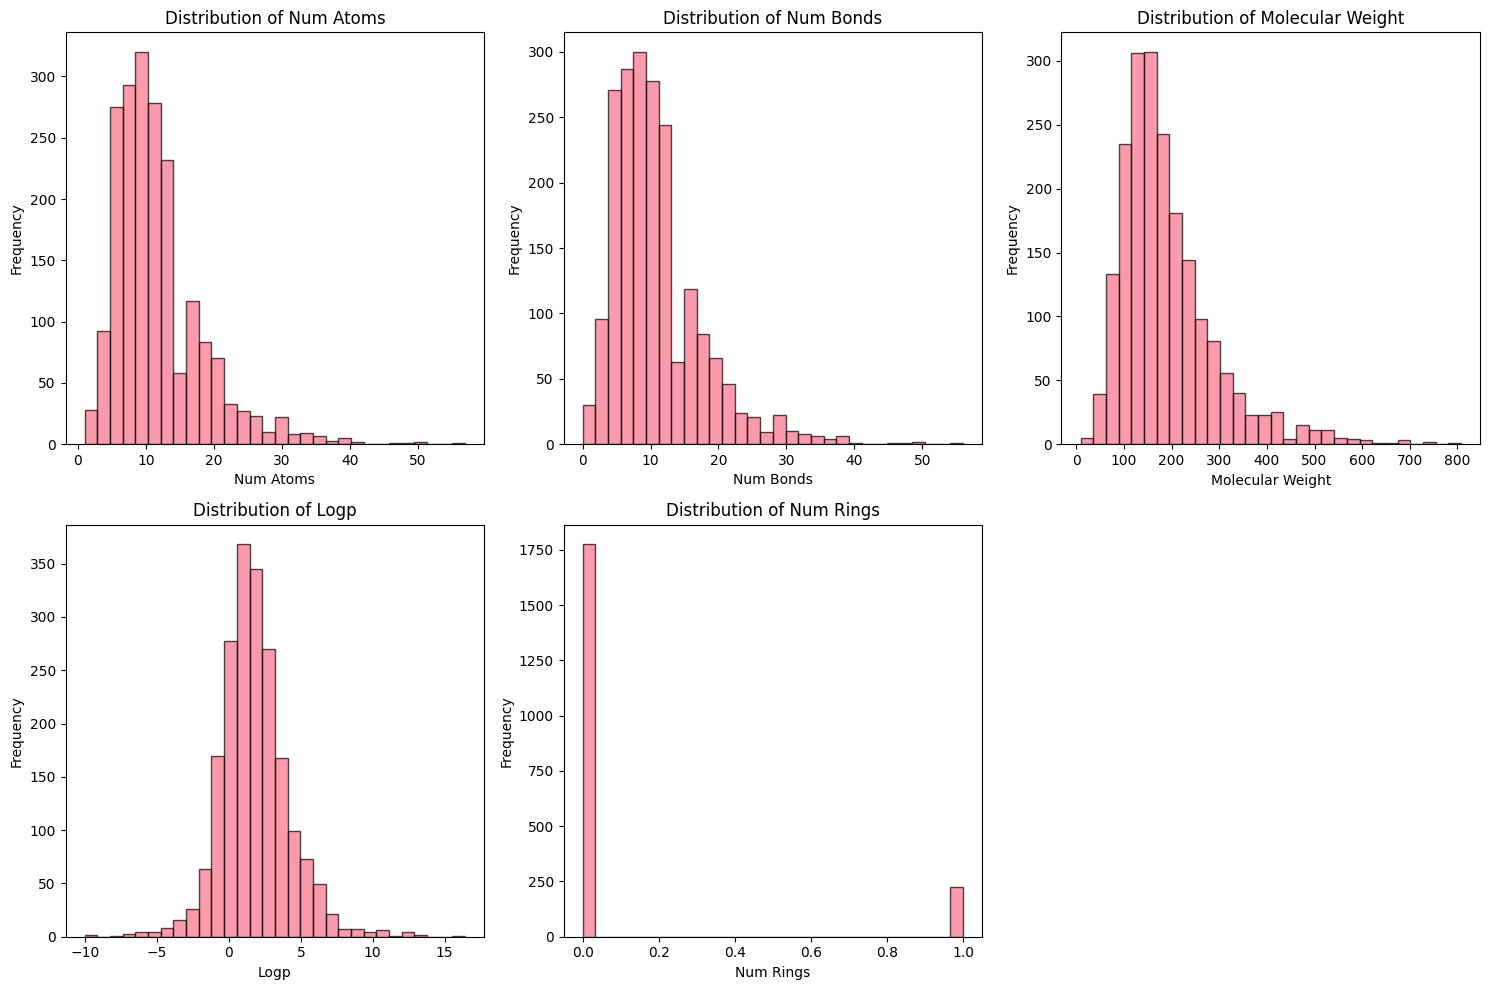

In [6]:
# Visualize molecular property distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

properties = ['num_atoms', 'num_bonds', 'molecular_weight', 'logp', 'num_rings']
for i, prop in enumerate(properties):
    axes[i].hist(mol_df[prop], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {prop.replace("_", " ").title()}')
    axes[i].set_xlabel(prop.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')

# Remove empty subplot
axes[-1].remove()
plt.tight_layout()
plt.show()

# Graph Conversion and Feature Analysis

In [7]:
# Convert sample molecules to graphs and analyze
sample_graphs = []
conversion_stats = {'successful': 0, 'failed': 0, 'too_large': 0}

print("Converting molecules to graphs...")
for i, smiles in enumerate(sample_smiles[:20]):  # First 20 for detailed analysis
    graph = dataset.smiles_to_graph(smiles)
    if graph is not None:
        sample_graphs.append(graph)
        conversion_stats['successful'] += 1
        print(f"✓ {i+1:2d}: {smiles[:50]:<50} -> {graph.x.shape[0]:2d} atoms, {graph.edge_index.shape[1]:2d} edges")
    else:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None and mol.GetNumAtoms() > dataset.max_atoms:
            conversion_stats['too_large'] += 1
            print(f"✗ {i+1:2d}: {smiles[:50]:<50} -> Too large ({mol.GetNumAtoms()} atoms)")
        else:
            conversion_stats['failed'] += 1
            print(f"✗ {i+1:2d}: {smiles[:50]:<50} -> Conversion failed")

print(f"\nConversion Statistics: {conversion_stats}")

Converting molecules to graphs...
✓  1: CC(O)(P(=O)(O)O)P(=O)(O)O                          -> 11 atoms, 20 edges
✓  2: CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C               -> 20 atoms, 38 edges
✓  3: OC[C@H](O)[C@@H](O)[C@H](O)CO                      -> 10 atoms, 18 edges
✓  4: CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]           -> 21 atoms, 36 edges
✓  5: CC(C)COC(=O)C(C)C                                  -> 10 atoms, 18 edges
✓  6: C=C(C)C(=O)OCCOC(=O)C(=C)C                         -> 14 atoms, 26 edges
✓  7: CCCCCCCCCCOCC(O)CN                                 -> 16 atoms, 30 edges
✓  8: C#CCO                                              ->  4 atoms,  6 edges
✓  9: CC(O)CC(C)(C)O                                     ->  8 atoms, 14 edges
✓ 10: CC(C)(C)CC(C)(C)N                                  ->  9 atoms, 16 edges

Conversion Statistics: {'successful': 10, 'failed': 0, 'too_large': 0}


In [8]:
# Analyze atom and bond feature distributions
def analyze_graph_features(graphs):
    """Analyze the features extracted from molecular graphs"""
    all_atom_features = []
    all_bond_features = []
    graph_sizes = []

    for graph in graphs:
        all_atom_features.append(graph.x.numpy())
        if graph.edge_attr.shape[0] > 0:
            all_bond_features.append(graph.edge_attr.numpy())
        graph_sizes.append(graph.x.shape[0])

    atom_features = np.vstack(all_atom_features)
    bond_features = np.vstack(all_bond_features) if all_bond_features else np.array([])

    return {
        'atom_features': atom_features,
        'bond_features': bond_features,
        'graph_sizes': graph_sizes
    }

In [9]:
# Analyze features
feature_stats = analyze_graph_features(sample_graphs)

print(f"Atom features shape: {feature_stats['atom_features'].shape}")
print(f"Bond features shape: {feature_stats['bond_features'].shape}")
print(f"Graph sizes: min={min(feature_stats['graph_sizes'])}, max={max(feature_stats['graph_sizes'])}, avg={np.mean(feature_stats['graph_sizes']):.1f}")


Atom features shape: (123, 37)
Bond features shape: (222, 10)
Graph sizes: min=4, max=21, avg=12.3


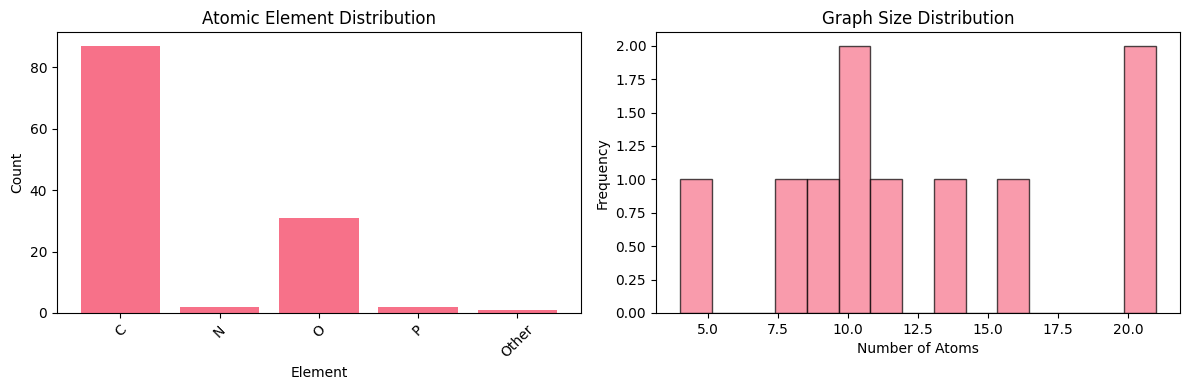

In [10]:
# Visualize feature distributions
if len(feature_stats['atom_features']) > 0:
    # Plot atom feature distributions
    atom_features = feature_stats['atom_features']

    # Atomic number distribution (first 11 features are one-hot encoded atomic numbers)
    atomic_nums = np.argmax(atom_features[:, :11], axis=1)
    atomic_elements = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    unique, counts = np.unique(atomic_nums, return_counts=True)
    element_labels = [atomic_elements[i] for i in unique]
    plt.bar(element_labels, counts)
    plt.title('Atomic Element Distribution')
    plt.xlabel('Element')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.hist(feature_stats['graph_sizes'], bins=15, alpha=0.7, edgecolor='black')
    plt.title('Graph Size Distribution')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Molecular Visualisation

Sample molecules from the dataset:


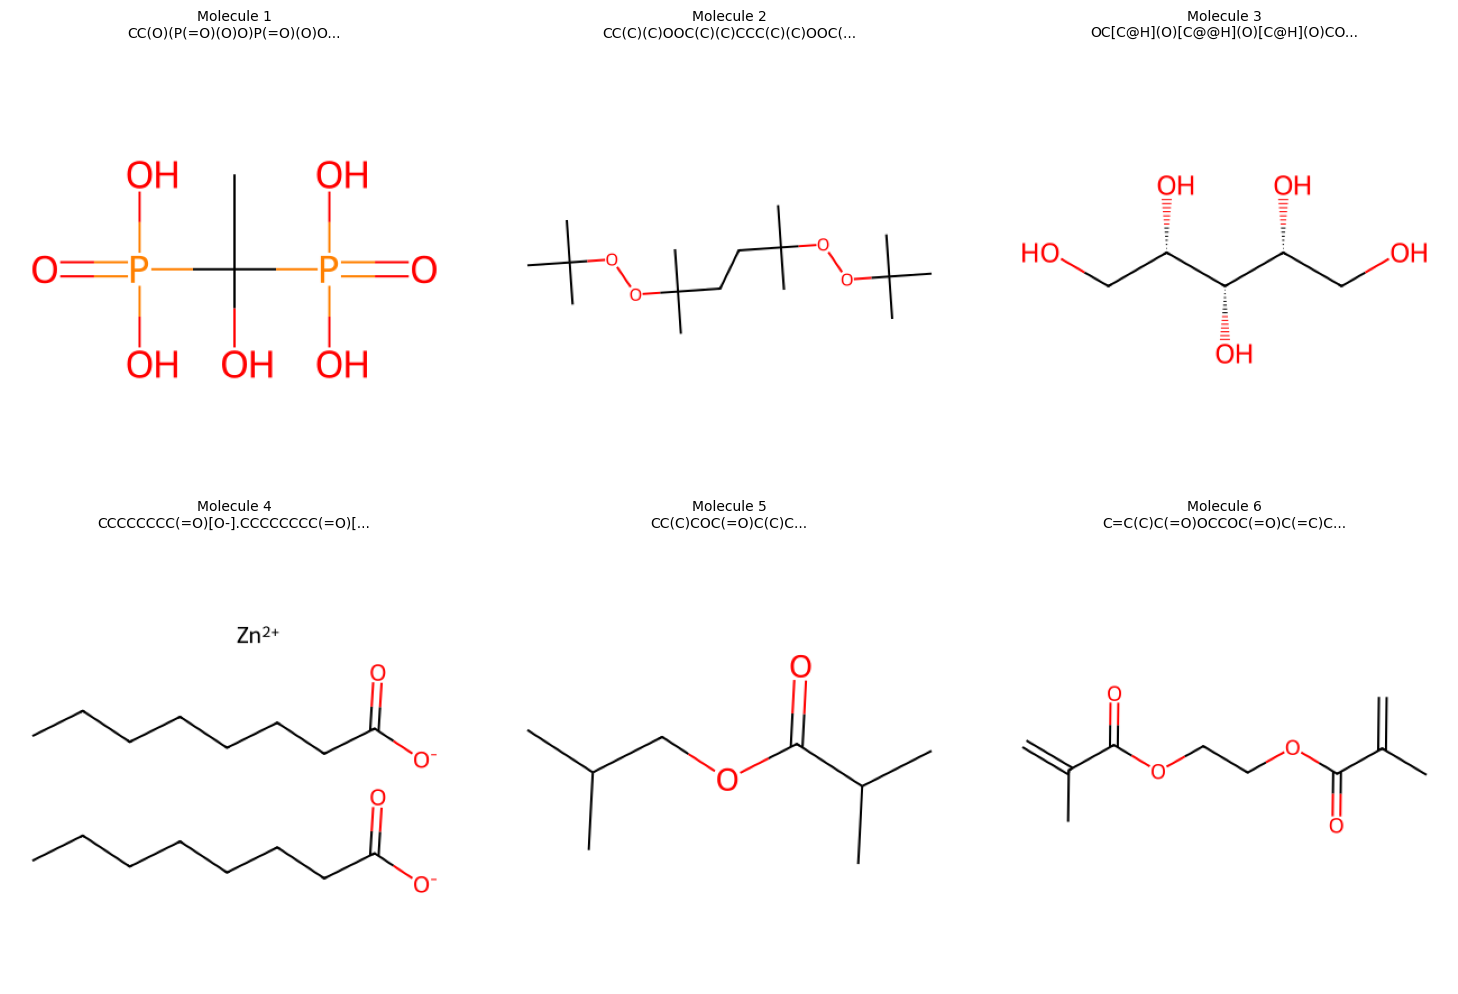

In [11]:
def visualize_sample_molecules(smiles_list, num_samples=6):
    """Visualize sample molecules from SMILES"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(min(num_samples, len(smiles_list))):
        mol = Chem.MolFromSmiles(smiles_list[i])
        if mol is not None:
            img = Draw.MolToImage(mol, size=(400, 400))
            axes[i].imshow(img)
            axes[i].set_title(f'Molecule {i+1}\n{smiles_list[i][:30]}...', fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, 'Invalid\nSMILES', ha='center', va='center',
                        transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(f'Molecule {i+1} (Invalid)')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample molecules
print("Sample molecules from the dataset:")
visualize_sample_molecules(sample_smiles[:6])


# DataLoader Testing

In [12]:
# Create and test dataloader
print("Creating DataLoader...")
dataloader = dataset.create_dataloader(batch_size=8, shuffle=True)

# Test the dataloader
print("\nTesting DataLoader:")
for i, batch in enumerate(dataloader):
    batch_size = batch.batch.max().item() + 1
    print(f"Batch {i+1}:")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Total nodes: {batch.x.shape[0]}")
    print(f"  - Node features: {batch.x.shape}")
    print(f"  - Edge indices: {batch.edge_index.shape}")
    print(f"  - Edge features: {batch.edge_attr.shape}")
    print(f"  - Average nodes per graph: {batch.x.shape[0] / batch_size:.1f}")

    if i >= 2:  # Only show first 3 batches
        break

INFO:diffusion_gnn.data.deepchem:Converting 6258 molecules to graphs...
INFO:diffusion_gnn.data.deepchem:Processed 0/6258 molecules...


Creating DataLoader...


[14:38:25] WARNING: not removing hydrogen atom without neighbors
INFO:diffusion_gnn.data.deepchem:Processed 1000/6258 molecules...
INFO:diffusion_gnn.data.deepchem:Processed 2000/6258 molecules...
INFO:diffusion_gnn.data.deepchem:Processed 3000/6258 molecules...
INFO:diffusion_gnn.data.deepchem:Processed 4000/6258 molecules...
INFO:diffusion_gnn.data.deepchem:Processed 5000/6258 molecules...
INFO:diffusion_gnn.data.deepchem:Processed 6000/6258 molecules...
INFO:diffusion_gnn.data.deepchem:Successfully converted 5856/6258 molecules (93.6%)
INFO:diffusion_gnn.data.deepchem:Failed conversions: 402



Testing DataLoader:
Batch 1:
  - Batch size: 8
  - Total nodes: 135
  - Node features: torch.Size([135, 37])
  - Edge indices: torch.Size([2, 280])
  - Edge features: torch.Size([280, 10])
  - Average nodes per graph: 16.9
Batch 2:
  - Batch size: 8
  - Total nodes: 122
  - Node features: torch.Size([122, 37])
  - Edge indices: torch.Size([2, 260])
  - Edge features: torch.Size([260, 10])
  - Average nodes per graph: 15.2
Batch 3:
  - Batch size: 8
  - Total nodes: 145
  - Node features: torch.Size([145, 37])
  - Edge indices: torch.Size([2, 302])
  - Edge features: torch.Size([302, 10])
  - Average nodes per graph: 18.1


# Feature Quality Assessment

In [13]:
# Check feature quality and identify potential issues
def assess_feature_quality(dataloader, num_batches=5):
    """Assess the quality of extracted features"""
    stats = {
        'total_graphs': 0,
        'total_nodes': 0,
        'total_edges': 0,
        'nan_features': 0,
        'inf_features': 0,
        'zero_degree_nodes': 0,
        'isolated_graphs': 0
    }

    node_features_all = []
    edge_features_all = []

    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break

        batch_size = batch.batch.max().item() + 1
        stats['total_graphs'] += batch_size
        stats['total_nodes'] += batch.x.shape[0]
        stats['total_edges'] += batch.edge_index.shape[1]

        # Check for NaN or Inf values
        stats['nan_features'] += torch.isnan(batch.x).sum().item()
        stats['inf_features'] += torch.isinf(batch.x).sum().item()

        # Check for isolated nodes (degree 0)
        degrees = torch.bincount(batch.edge_index[0], minlength=batch.x.shape[0])
        stats['zero_degree_nodes'] += (degrees == 0).sum().item()

        # Check for isolated graphs (no edges)
        if batch.edge_index.shape[1] == 0:
            stats['isolated_graphs'] += batch_size

        node_features_all.append(batch.x)
        edge_features_all.append(batch.edge_attr)

    # Compute feature statistics
    all_node_features = torch.cat(node_features_all, dim=0)
    all_edge_features = torch.cat(edge_features_all, dim=0)

    print("Feature Quality Assessment:")
    print(f"  - Total graphs analyzed: {stats['total_graphs']}")
    print(f"  - Average nodes per graph: {stats['total_nodes'] / stats['total_graphs']:.2f}")
    print(f"  - Average edges per graph: {stats['total_edges'] / stats['total_graphs']:.2f}")
    print(f"  - NaN features: {stats['nan_features']}")
    print(f"  - Inf features: {stats['inf_features']}")
    print(f"  - Zero-degree nodes: {stats['zero_degree_nodes']}")
    print(f"  - Isolated graphs: {stats['isolated_graphs']}")

    print(f"\nNode feature statistics:")
    print(f"  - Min: {all_node_features.min().item():.4f}")
    print(f"  - Max: {all_node_features.max().item():.4f}")
    print(f"  - Mean: {all_node_features.mean().item():.4f}")
    print(f"  - Std: {all_node_features.std().item():.4f}")

    if all_edge_features.numel() > 0:
        print(f"\nEdge feature statistics:")
        print(f"  - Min: {all_edge_features.min().item():.4f}")
        print(f"  - Max: {all_edge_features.max().item():.4f}")
        print(f"  - Mean: {all_edge_features.mean().item():.4f}")
        print(f"  - Std: {all_edge_features.std().item():.4f}")

assess_feature_quality(dataloader)

Feature Quality Assessment:
  - Total graphs analyzed: 40
  - Average nodes per graph: 14.15
  - Average edges per graph: 28.60
  - NaN features: 0
  - Inf features: 0
  - Zero-degree nodes: 0
  - Isolated graphs: 0

Node feature statistics:
  - Min: 0.0000
  - Max: 1.0000
  - Mean: 0.1452
  - Std: 0.3523

Edge feature statistics:
  - Min: 0.0000
  - Max: 1.0000
  - Mean: 0.2962
  - Std: 0.4566


# Model Architecture Testing

In [14]:
# Test the model architecture with sample data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [15]:
# Get feature dimensions
atom_dim = dataset._get_atom_feature_dim()
bond_dim = dataset._get_bond_feature_dim()

print(f"Atom feature dim: {atom_dim}")
print(f"Bond feature dim: {bond_dim}")

# Initialize a small model for testing
model = MolecularDiffusionGNN(
    atom_dim=atom_dim,
    bond_dim=bond_dim,
    hidden_dim=64,  # Smaller for testing
    num_layers=2,
    max_atoms=30
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Atom feature dim: 37
Bond feature dim: 10
Model parameters: 60,005


In [16]:
# Test forward pass
model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        batch_size = batch.batch.max().item() + 1

        # Create dummy timesteps
        t = torch.randint(0, 1000, (batch_size,), device=device)

        # Forward pass
        output = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch, t)

        print(f"Forward pass successful!")
        print(f"Input shape: {batch.x.shape}")
        print(f"Output shape: {output.shape}")
        print(f"Output range: [{output.min().item():.4f}, {output.max().item():.4f}]")
        break

Forward pass successful!
Input shape: torch.Size([113, 37])
Output shape: torch.Size([113, 37])
Output range: [-0.1897, 0.1264]


# Training Preparation

In [17]:
# Initialize DDPM for testing
ddpm = MolecularDDPM(model, num_timesteps=100, device=device)  # Fewer timesteps for testing

# Test loss computation
model.train()
for batch in dataloader:
    batch = batch.to(device)

    # Compute loss
    loss = ddpm.training_loss(batch)
    print(f"Training loss: {loss.item():.6f}")

    # Test backward pass
    loss.backward()
    print("Backward pass successful!")
    break

Training loss: 1.036330
Backward pass successful!



## Next Steps

Based on this exploration:

1. **Data Quality**: Features look good, no NaN/Inf values detected
2. **Model Architecture**: Forward and backward passes work correctly
3. **Scalability**: Ready to move to larger datasets (ZINC15) and bigger models

### Recommendations:
- Move training loop to separate script for longer runs
- Implement checkpointing and logging
- Add validation metrics
- Experiment with different GNN architectures
- Scale up hidden dimensions and layers for production runs
